<a href="https://colab.research.google.com/github/Whoami666/HSE_Lab/blob/main/clean_models/schiz_models_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.4 MB/s eta 0:00:00


In [5]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 16.8 MB/s eta 0:00:00


In [6]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import sklearn.metrics
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

from sklearn.model_selection import KFold

In [19]:
def calculate_scores(model, givenx, giveny, xtest):
  kf = KFold(n_splits=10)
  crossval_f1 = cross_val_score(model, givenx, giveny, scoring='f1_macro', cv = kf, verbose=False)
  mean_score = crossval_f1.mean()
  std_score = crossval_f1.std()
  print('f1_macro', mean_score, '±', std_score)

  crossval_accuracy = cross_val_score(model, givenx, giveny, scoring='accuracy', cv = kf, verbose=False)
  mean_score = crossval_accuracy.mean()
  std_score = crossval_accuracy.std()
  print('accuracy', mean_score, '±', std_score)

  crossval_recall = cross_val_score(model, givenx, giveny, scoring='recall_macro', cv = kf, verbose=False)
  mean_score = crossval_recall.mean()
  std_score = crossval_recall.std()
  print('recall', mean_score, '±', std_score)

  if giveny.nunique() == 2:
    y_proba = model.predict_proba(xtest)
    print('roc_auc_score', roc_auc_score(y_test, y_proba[:,1]))

In [20]:
def catboost_class(xtrain, ytrain, xtest, ytest, xgiven, ygiven):
  warnings.filterwarnings('ignore')

  opt = BayesSearchCV(
      CatBoostClassifier(),
      {
          'depth': [4,5,6,7,8,9, 10],
          'learning_rate' : [0.01,0.02,0.03,0.04],
          'iterations'    : [10, 20,30,40,50,60,70,80,90, 100],
      },
      n_iter=32,
      scoring='f1_macro',
      cv=3
  )

  opt.fit(xtrain, ytrain, logging_level='Silent')
  print("val. score: %s" % opt.best_score_)
  print("test score: %s" % opt.score(xtest, ytest))
  print("best_params: %s" % opt.best_params_, '\n')

  cbc = CatBoostClassifier(depth = opt.best_params_['depth'], 
                             iterations = opt.best_params_['iterations'],
                             learning_rate = opt.best_params_['learning_rate'])
  cbc.fit(xtrain, ytrain, logging_level='Silent')
  y_pred = cbc.predict(xtest)
  print(classification_report(ytest,y_pred))

  calculate_scores(cbc, xgiven, ygiven, xtest)

  sorted_idx = cbc.feature_importances_.argsort()
  feature_names = [f"feature {i}" for i in range(X.shape[1])]
  plt.barh(X.columns[sorted_idx], cbc.feature_importances_[sorted_idx])
  plt.xlabel("Catboost Feature Importance")

In [9]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [21]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=32)

val. score: 0.5647020556856622
test score: 0.32569974554707376
best_params: OrderedDict([('depth', 5), ('iterations', 90), ('learning_rate', 0.04)]) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        64
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2

    accuracy                           0.94        68
   macro avg       0.32      0.33      0.33        68
weighted avg       0.90      0.94      0.92        68

0:	learn: 1.0651223	total: 3.36ms	remaining: 299ms
1:	learn: 1.0298897	total: 6.85ms	remaining: 301ms
2:	learn: 0.9955630	total: 9.99ms	remaining: 290ms
3:	learn: 0.9641043	total: 12.9ms	remaining: 276ms
4:	learn: 0.9311225	total: 15.5ms	remaining: 264ms
5:	learn: 0.9025311	total: 18.4ms	remaining: 258ms
6:	learn: 0.8791066	total: 21.4ms	remaining: 253ms
7:	learn: 0.8482034	total: 21.9ms	remaining: 225ms
8:	learn: 0.8235854	total: 25ms	remaining: 225ms
9:	learn: 0

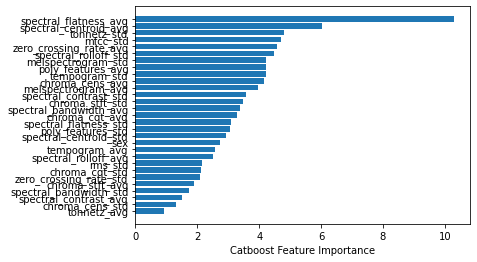

In [22]:
catboost_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [12]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.4208002645502645
test score: 0.3125
best_params: OrderedDict([('depth', 9), ('iterations', 10), ('learning_rate', 0.02)]) 

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.88        68
   macro avg       0.29      0.33      0.31        68
weighted avg       0.78      0.88      0.83        68

0:	learn: 1.0763016	total: 15.2ms	remaining: 137ms
1:	learn: 1.0627582	total: 30.5ms	remaining: 122ms
2:	learn: 1.0493707	total: 48.4ms	remaining: 113ms
3:	learn: 1.0335527	total: 62.9ms	remaining: 94.4ms
4:	learn: 1.0212780	total: 78.1ms	remaining: 78.1ms
5:	learn: 1.0105662	total: 93.2ms	remaining: 62.2ms
6:	learn: 0.9986611	total: 109ms	remaining: 46.5ms
7:	learn: 0.9817584	total: 125ms	remaining: 31.2ms
8:	learn: 0.9697873	total: 139ms	remaining: 15.5ms
9:	learn: 0.9570152

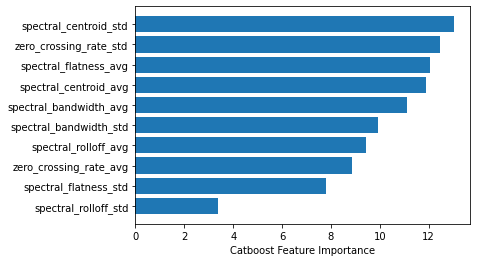

In [13]:
catboost_class(X_train, y_train, X_test, y_test, X, y)

**Binary**

All features

In [14]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

NameError: ignored

val. score: 0.6549651567944251
test score: 0.48484848484848486
best_params: OrderedDict([('depth', 5), ('iterations', 80), ('learning_rate', 0.04)]) 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.00      0.00      0.00         2

    accuracy                           0.94        34
   macro avg       0.47      0.50      0.48        34
weighted avg       0.89      0.94      0.91        34

0:	learn: 0.6551693	total: 5.55ms	remaining: 438ms
1:	learn: 0.6156858	total: 9.94ms	remaining: 388ms
2:	learn: 0.5779538	total: 12.8ms	remaining: 330ms
3:	learn: 0.5489503	total: 15.5ms	remaining: 294ms
4:	learn: 0.5075641	total: 18ms	remaining: 270ms
5:	learn: 0.4872492	total: 20.7ms	remaining: 256ms
6:	learn: 0.4595162	total: 23.9ms	remaining: 249ms
7:	learn: 0.4406117	total: 26.8ms	remaining: 241ms
8:	learn: 0.4188617	total: 30ms	remaining: 236ms
9:	learn: 0.4026387	total: 35.3ms	remaining: 247ms
10:	learn: 0.381

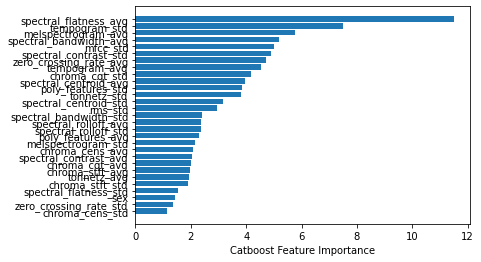

In [15]:
catboost_class(X_train, y_train, X_test, y_test, X, y)

Only 1D features

In [16]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

val. score: 0.5403769841269841
test score: 0.6761904761904762
best_params: OrderedDict([('depth', 9), ('iterations', 80), ('learning_rate', 0.04)]) 

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        60
           1       1.00      0.25      0.40         8

    accuracy                           0.91        68
   macro avg       0.95      0.62      0.68        68
weighted avg       0.92      0.91      0.89        68

0:	learn: 0.6731942	total: 6.63ms	remaining: 524ms
1:	learn: 0.6598975	total: 13.3ms	remaining: 519ms
2:	learn: 0.6511786	total: 19.3ms	remaining: 494ms
3:	learn: 0.6396103	total: 25.9ms	remaining: 493ms
4:	learn: 0.6278451	total: 32.6ms	remaining: 489ms
5:	learn: 0.6178355	total: 39.1ms	remaining: 482ms
6:	learn: 0.6074945	total: 46.6ms	remaining: 486ms
7:	learn: 0.5958360	total: 53.4ms	remaining: 481ms
8:	learn: 0.5869363	total: 60.2ms	remaining: 475ms
9:	learn: 0.5750234	total: 67.4ms	remaining: 472ms
10:	learn: 0.

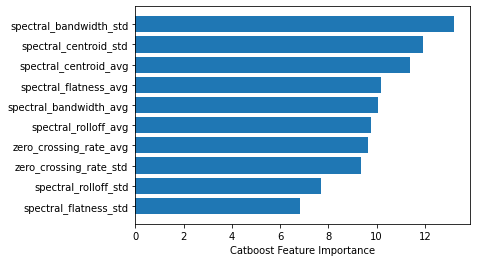

In [17]:
catboost_class(X_train, y_train, X_test, y_test, X, y)